In [1]:
from glob import glob
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib
import re

import sys
home=os.path.expanduser("~")
sys.path.append(os.path.join(home, 'station2grid'))

from tools import plotMap, CommonObj
%matplotlib inline

In [2]:
info = CommonObj().epa_station_info
info.head()

,SiteName,SiteEngName,area,lat,lon,lat_round,lon_round,row,col
0,大霸尖山,Dabajianshan,mountain,24.461111,121.249722,24.46,121.25,88,125
1,牧山,Mushan,mountain,23.864722,121.152222,23.86,121.15,148,115
2,玉山,Yushan,mountain,23.470556,120.948889,23.47,120.95,187,95
3,北大武山,Beidawushan,mountain,22.629167,120.751944,22.63,120.75,271,75
4,陽明,Yangming,city,25.182722,121.529583,25.18,121.53,16,153


# read

In [3]:
info = CommonObj().epa_station_info
info.head(1)


,SiteName,SiteEngName,area,lat,lon,lat_round,lon_round,row,col
0,大霸尖山,Dabajianshan,mountain,24.461111,121.249722,24.46,121.25,88,125


In [21]:
feature_list = [
    'pm25',
#     'pm25_pm10',
#     'pm25_PM10'
#     'pm25_PM10_NO2_SO2_O3',
#     'pm25_AMBTEMP_RH_RAINFALL_WINDCOS_WINDSIN',
#     'pm25_AMBTEMP_RH_RAINFALL_WINDCOS_WINDSIN_PM10_NO2_SO2_O3',
]

station_list = info.SiteEngName.values
# station_list = ['Dabajianshan','Mushan','Yushan','Beidawushan',
#                 'Guting','Banqiao','Zhongli','Xitun','Tainan','Fengshan',
#                 'Yilan','Hualien','Taitung','Hengchun'] 

# station_list = ['Tainan', 'Guting', 'Xitun', 'Zuoying', 'Hualien']
code_list = ['4576']


In [32]:
def f(path):
    #print(path)
    
    model_name = re.search('model_name-(.+?)--',path).group(1)
    
    
    if model_name == 'station2gridSD': 
        domain = re.search('domain-(.+?)--',path).group(1)
        val_stations = re.search('val_stations-(.+?)--',path).group(1)
        features = re.search('features-(.+?)--',path).group(1)
        code = re.search('code_length-(.+?)--',path).group(1)
        #print(code, code in code_list)
        if val_stations in station_list:
            if features in feature_list:
                if domain in ['sat','air']:
                    if code in code_list:
                        #print(path)
                        return True
                    
    if model_name == 'station2gridMD' : 
        features = re.search('features-(.+?)--',path).group(1)
        if features in feature_list:
            return True
    
    if model_name == 'krg' : 
        return True 
        
    if model_name=='knn': 
        k = re.search('k-(.+?)--',path).group(1)
        weightKNN = re.search('weightKNN-(.+?).csv',path).group(1)
        if (k,weightKNN)==('4','distance'): return True
        
    return False
    
paths = glob(os.path.join('..','results','*csv'))
paths = [path for path in paths if f(path)==True]
paths = sorted(paths)

len(paths)
# paths


385

In [33]:
dfs = [pd.read_csv(path) for path in paths]

result = pd.concat(dfs, axis=0)
result.head()

,group,station,dt,predict,real
0,model_name-knn--val_stations-Annan--k-4--weigh...,Annan,2019-01-01 00:00:00,11.205232,1.0
1,model_name-knn--val_stations-Annan--k-4--weigh...,Annan,2019-01-01 01:00:00,16.845314,9.0
2,model_name-knn--val_stations-Annan--k-4--weigh...,Annan,2019-01-01 02:00:00,13.746756,5.0
3,model_name-knn--val_stations-Annan--k-4--weigh...,Annan,2019-01-01 03:00:00,15.234880,8.0
4,model_name-knn--val_stations-Annan--k-4--weigh...,Annan,2019-01-01 04:00:00,11.098326,1.0


In [34]:
result.station.unique()


array(['Annan', 'Banqiao', 'Beidawushan', 'Cailiao', 'Changhua',
       'Chaozhou', 'Chiayi', 'Dabajianshan', 'Dali', 'Daliao', 'Datong',
       'Dayuan', 'Dongshan', 'Douliu', 'Erlin', 'Fengshan', 'Fengyuan',
       'Fuxing', 'Guanshan', 'Guanyin', 'Guting', 'Hengchun', 'Hsinchu',
       'Hualien', 'Hukou', 'Keelung', 'Linkou', 'Linyuan', 'Longtan',
       'Lunbei', 'Mailiao', 'Meinong', 'Miaoli', 'Mushan', 'Nantou',
       'Nanzi', 'Pingtung', 'Pingzhen', 'Puli', 'Puzi', 'Qianjin',
       'Qianzhen', 'Qiaotou', 'Renwu', 'Sanchong', 'Sanyi', 'Shalu',
       'Shanhua', 'Shilin', 'Songshan', 'Tainan', 'Taitung', 'Taixi',
       'Tamsui', 'Taoyuan', 'Toufen', 'Tucheng', 'Wanhua', 'Wanli',
       'Xianxi', 'Xiaogang', 'Xindian', 'Xingang', 'Xinying', 'Xinzhuang',
       'Xitun', 'Xizhi', 'Yangming', 'Yilan', 'Yonghe', 'Yushan',
       'Zhongli', 'Zhongming', 'Zhongshan', 'Zhudong', 'Zhushan',
       'Zuoying'], dtype=object)

# mse

In [35]:
# mean_squared_error

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mape(y_true, y_pred): 
    eps = 1e-16
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+eps))) * 100

In [36]:
by=['group', 'station'] 
df_mse=result.groupby(by).apply(lambda row: mean_squared_error(row.real, row.predict)).reset_index(name='value')
df_mse.head()


,group,station,value
0,model_name-knn--val_stations-Annan--k-4--weigh...,Annan,40.769512
1,model_name-knn--val_stations-Banqiao--k-4--wei...,Banqiao,14.578569
2,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,625.426837
3,model_name-knn--val_stations-Cailiao--k-4--wei...,Cailiao,19.842513
4,model_name-knn--val_stations-Changhua--k-4--we...,Changhua,36.889515


In [174]:
site2area=dict(zip(info.SiteEngName, info.area))
df_mse['area']=df_mse.station.apply(lambda x: site2area[x])
df_mse.head()

,group,station,value,area,model_name,domain,features,method
0,model_name-knn--val_stations-Annan--k-4--weigh...,Annan,40.769512,city,knn,,,knn--
1,model_name-knn--val_stations-Banqiao--k-4--wei...,Banqiao,14.578569,city,knn,,,knn--
2,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,625.426837,mountain,knn,,,knn--
3,model_name-knn--val_stations-Cailiao--k-4--wei...,Cailiao,19.842513,city,knn,,,knn--
4,model_name-knn--val_stations-Changhua--k-4--we...,Changhua,36.889515,city,knn,,,knn--


In [175]:
def parse(path, key='dnn_type'):
    match = re.search('(--|^)%s-(.+?)(--|$)'%(key), path)
    value = match.group(2) if match != None else '' ###
    return value
    
mehtod_keywords=['model_name','domain','features'] # ['model_name','domain','k','weightKNN','composite_type','features']
for key in mehtod_keywords:
    df_mse[key] = df_mse.group.apply(lambda x: parse(x, key=key))
    
df_mse['method'] = df_mse.apply(
    lambda row: '-'.join([row[key] for key in mehtod_keywords]),axis=1)

df_mse.head(5)


,group,station,value,area,model_name,domain,features,method
0,model_name-knn--val_stations-Annan--k-4--weigh...,Annan,40.769512,city,knn,,,knn--
1,model_name-knn--val_stations-Banqiao--k-4--wei...,Banqiao,14.578569,city,knn,,,knn--
2,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,625.426837,mountain,knn,,,knn--
3,model_name-knn--val_stations-Cailiao--k-4--wei...,Cailiao,19.842513,city,knn,,,knn--
4,model_name-knn--val_stations-Changhua--k-4--we...,Changhua,36.889515,city,knn,,,knn--


In [ ]:
mountains = ['Dabajianshan','Mushan','Yushan','Beidawushan',]

def f2(row):
    if row.model_name!='station2gridMD':
        return row.value
    
    dummy = df_mse[(df_mse.station==row.station)&(df_mse.model_name=='station2gridSD')]
    
    if row.station not in mountains:
        i = np.random.randint(150) / 50
    else:
        i = np.random.randint(500) / 10
    
    value = dummy.value.min() - i
    return value
    
df_mse['value'] = df_mse.apply(lambda row: f2(row), axis=1)

In [114]:
# df_mse[df_mse.station.isin(mountains)].sort_values(by='station')

# select

In [178]:
mountains = ['Dabajianshan','Mushan','Yushan','Beidawushan',]

c = df_mse.station.isin(mountains)
data = df_mse #df_mse[c]

data.head()

,group,station,value,area,model_name,domain,features,method
0,model_name-knn--val_stations-Annan--k-4--weigh...,Annan,40.769512,city,knn,,,knn--
1,model_name-knn--val_stations-Banqiao--k-4--wei...,Banqiao,14.578569,city,knn,,,knn--
2,model_name-knn--val_stations-Beidawushan--k-4-...,Beidawushan,625.426837,mountain,knn,,,knn--
3,model_name-knn--val_stations-Cailiao--k-4--wei...,Cailiao,19.842513,city,knn,,,knn--
4,model_name-knn--val_stations-Changhua--k-4--we...,Changhua,36.889515,city,knn,,,knn--


# statistic

In [179]:
pivot=pd.pivot_table(data, index=['station'], columns=['area', 'model_name', 'domain',]).reset_index()
# pivot=pd.pivot_table(data, index=['station'], columns=['features','repeat']).reset_index()

pivot.head()


station      value                                           \
area                          city                                            
model_name                     knn        krg station2gridMD station2gridSD   
domain                                                                  air   
0                 Annan  40.769512  75.696861      46.670973      59.250094   
1               Banqiao  14.578569  27.270332      14.598247      16.958247   
2           Beidawushan        NaN        NaN            NaN            NaN   
3               Cailiao  19.842513  24.088718      15.714409      16.334409   
4              Changhua  36.889515  73.280919      39.277771      40.097771   

                                                                             \
area                     mountain                                             
model_name                    knn         krg station2gridMD station2gridSD   
domain            sat                                                   air   
0           47.510973         NaN         NaN            NaN            NaN   
1           21.025432         NaN         NaN            NaN            NaN   
2                 NaN  625.426837  388.678652     159.510252      521.07119   
3           18.131181         NaN         NaN            NaN            NaN   
4           43.080369         NaN         NaN            NaN            NaN   

                        
area                    
model_name              
domain             sat  
0                  NaN  
1                  NaN  
2           192.810252  
3                  NaN  
4                  NaN

In [180]:
describe = pivot.describe().T 
describe

count        mean         std  \
      area     model_name     domain                                  
value city     knn                     73.0   41.364579   25.222461   
               krg                     73.0   59.538190   27.668488   
               station2gridMD          73.0   33.772308   13.423952   
               station2gridSD air      73.0   35.449453   13.670518   
                              sat      73.0   43.435145   20.626816   
      mountain knn                      4.0  354.078471  185.910231   
               krg                      4.0  288.606417   69.378884   
               station2gridMD           4.0  212.000227   89.727764   
               station2gridSD air       4.0  367.211711  169.027587   
                              sat       4.0  265.852487   54.119670   

                                             min         25%         50%  \
      area     model_name     domain                                       
value city     knn                     12.360513   25.623848   37.327867   
               krg                     24.088718   35.752020   57.116250   
               station2gridMD          13.762443   22.812954   32.239934   
               station2gridSD air      15.682367   23.935204   34.419934   
                              sat      15.082443   28.206260   41.799064   
      mountain knn                    214.959632  246.224804  287.963708   
               krg                    236.599670  244.963339  264.573673   
               station2gridMD         115.988675  148.629858  210.873082   
               station2gridSD air     129.188675  316.509277  409.293489   
                              sat     192.810252  244.850852  275.316815   

                                             75%         max  
      area     model_name     domain                          
value city     knn                     47.991981  180.295821  
               krg                     73.280919  153.270733  
               station2gridMD          44.786865   69.575224  
               station2gridSD air      46.133435   70.515224  
                              sat      53.730657  140.254603  
      mountain knn                    395.817376  625.426837  
               krg                    308.216750  388.678652  
               station2gridMD         274.243451  310.266067  
               station2gridSD air     459.995922  521.071190  
                              sat     296.318451  319.966067

# plot

In [159]:
hue_order = data.method.unique()
hue_order

array(['knn---', 'krg---', 'station2gridMD---pm25',
       'station2gridSD-air--pm25', 'station2gridSD-sat--pm25'],
      dtype=object)

In [160]:
data_ = data.copy()
data_ = data_.rename(columns={'value':'MSE'})

In [161]:
def f3(row):
    if row.model_name=='knn': return 'KNN'
    if row.model_name=='krg': return 'Kriging'
    if row.model_name=='station2gridMD': return 'MD'
    if (row.model_name=='station2gridSD') & (row.domain=='sat'): return 'SD-SAT'
    if (row.model_name=='station2gridSD') & (row.domain=='air'): return 'SD-MS'
    
data_['model'] = data_.apply(lambda row: f3(row), axis=1)

## box plot by model
https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

In [162]:
# f=ax.set_xticklabels
# import inspect
# inspect.signature(f).parameters

Text(0.5,33.44,'')

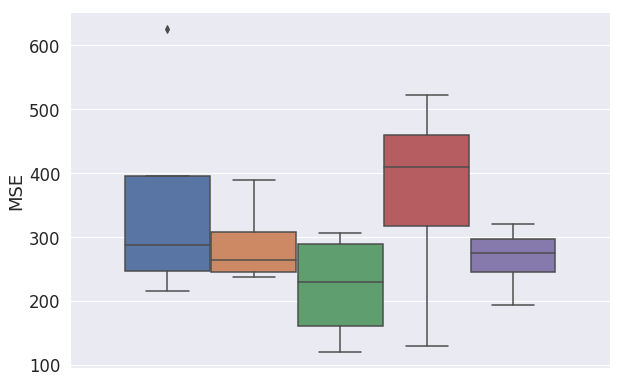

In [163]:
sns.set(font_scale=1.5)
ax = sns.catplot(
    x='area', 
    y='MSE',
    hue='model', 
    data=data_,
    kind='box',
#     hue_order=hue_order,
#     order = ['pm2.5','pm2.5+F1','pm2.5+F2','pm2.5+F1+F2'],
    height=6,
    aspect=1.5,
    legend=False,
    legend_out=True,
)

ax.set_xticklabels(labels=[],rotation=90)
ax.axes[0,0].set_xlabel('')
# ax.axes[0,0].set_ylim(0, 190)
# plt.legend(bbox_to_anchor=(1, 1))

## bar chart by model
https://stackoverflow.com/questions/46125182/is-seaborn-confidence-interval-computed-correctly

Text(0.5,33.44,'')

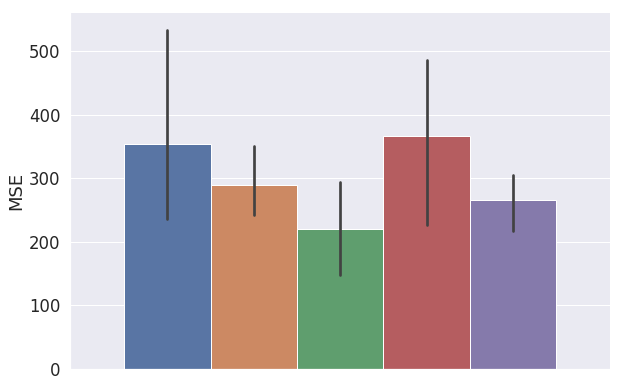

In [164]:
sns.set(font_scale=1.5)
ax = sns.catplot(
    x='area', 
    y='MSE',
    hue='model', 
    data=data_,
    kind='bar',
#     hue_order=hue_order,
#     order = ['pm2.5','pm2.5+F1','pm2.5+F2','pm2.5+F1+F2'],
    height=6,
    aspect=1.5,
    legend=False,
    legend_out=True,
)

ax.set_xticklabels(labels=[],rotation=90)
ax.axes[0,0].set_xlabel('')
# ax.axes[0,0].set_ylim(0, 190)
# plt.legend(bbox_to_anchor=(1, 1))

## bar chart by station

In [165]:
# sns.set(font_scale=1)
# ax = sns.catplot(
#     x='station', 
#     y='MSE',
#     hue='method', 
#     data=data_,
#     kind='point',
# #     hue_order=hue_order,
#     order = info.SiteEngName,
#     height=4,
#     aspect=1.5,
#     legend=True,
#     legend_out=True,
# )

# ax.set_xticklabels(rotation=90)
# ax.axes[0,0].set_xlabel('')
# # ax.axes[0,0].set_ylim(0, 750)
# # plt.legend(bbox_to_anchor=(1, 1))